In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from train import *
from tqdm.auto import trange
import torch.nn.functional as F
from config import config

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv("data/final.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
tst_size=20
trn, tst = data[:-tst_size], data[-tst_size:]

In [3]:
singlemodel= torch.load('model/singleAnn_AdamW_lookback96_forcast12_batch32_in96_out12_hidden_512_epochs_500')

In [4]:
singleparams = config['ANN']['model_params']
single_lookback_size = singleparams['single_lookback_size']
single_forcast_size = singleparams['single_forcast_size']
single_batch_size = singleparams['single_batch_size']

In [5]:
anndataset = ANNLoadData(data,single_lookback_size,single_forcast_size,tst_size,single_batch_size)
single_trn_dl , single_tst_dl, single_trn_ds = anndataset.scaling()

## 단기

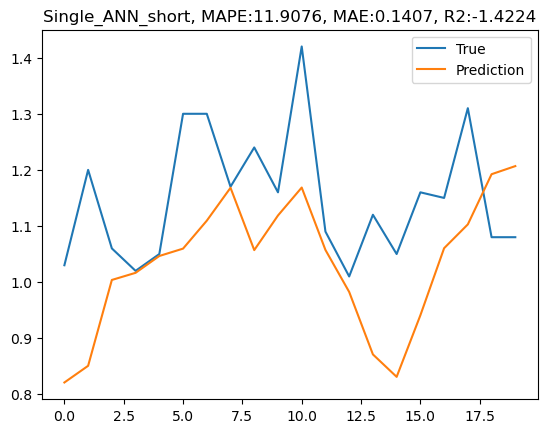

In [6]:
singlemodel.eval()
with torch.inference_mode():
  x, y = next(iter(single_tst_dl))
  x, y = x.to(device), y.to(device)
  p = singlemodel(x)

scalerann = anndataset.get_scaler()
y = scalerann.inverse_transform(y.cpu())
p = scalerann.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"Single_ANN_short, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

## 장기(dynamic)

<Axes: title={'center': 'Single_ANN_long, MAPE:34.4916, MAE:0.4029, R2:-16.345702411200588'}, xlabel='YearMonth'>

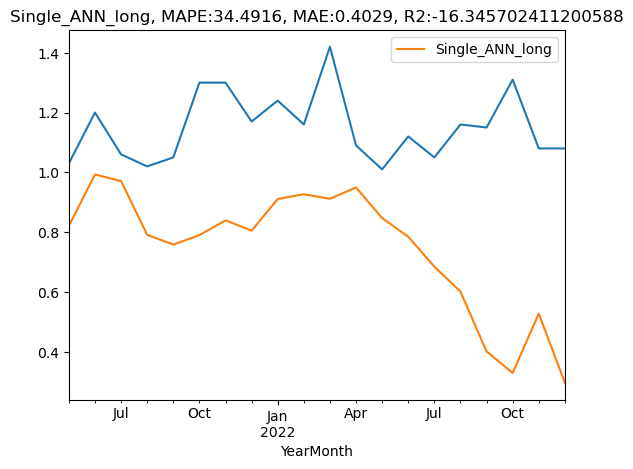

In [7]:
window_size = single_lookback_size
prediction_size = single_forcast_size
preds = []
tst_data  = data [-tst_size:]

singlemodel.to(device)

x, y = single_trn_ds[len(single_trn_ds)-1]

for _ in range(tst_size):
  y=y.squeeze()
  x = np.concatenate([x,y])[-window_size:]
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  y=singlemodel(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scalerann.inverse_transform(preds).squeeze()
preds = preds[:,0]

# 장기예측 plot
df = pd.DataFrame({"Single_ANN_long": preds}, index=tst_data.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
plt.title(f"Single_ANN_long, MAPE:{mape(preds,data.Temperature[-tst_size:].to_numpy()):.4f}, MAE:{mae(preds,data.Temperature[-tst_size:].to_numpy()):.4f}, R2:{r2_score(preds,data.Temperature[-tst_size:].to_numpy())}")
df.plot(ax=ax)